# NFL Fantasy Sports | Web Scraper | Linear Regression Predictions
## Kevin Veeder
---

### Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import requests
from bs4 import BeautifulSoup
import lxml

I'll need `pandas` and `numpy` for data manipulation, `sklearn` to build a linear regression model, and `requests` + `BeautifulSoup` for web scraping.

---

### Load and Prepare 2023 Fantasy Data

In [2]:
# pulling from pro football reference's '2024 NFL Fantasy Rankings' page

# IGNORE THE YEAR SYNTAX OF 'url_2023', if you have the url updated to previous season then everything is current.
url_2023 = "https://www.pro-football-reference.com/years/2024/fantasy.htm"
df_2023 = pd.read_html(url_2023, header=1)[0]
df_2023 = df_2023[df_2023['Rk'] != 'Rk']
df_2023 = df_2023.fillna(0)

Here I’m pulling 2023 fantasy football stats from Pro Football Reference. I clean up the table by removing repeated header rows and filling missing values.

---

### Feature Engineering for Model Training

In [3]:
df_2023['FantPt'] = pd.to_numeric(df_2023['FantPt'], errors='coerce')
df_2023['G'] = pd.to_numeric(df_2023['G'], errors='coerce')
# creating new column 'FPPG'
df_2023['FPPG'] = df_2023['FantPt'] / df_2023['G']

features = ['Att', 'Tgt', 'Rec', 'Cmp', 'Att.1']
# ensuring numericity
df_2023[features] = df_2023[features].apply(pd.to_numeric, errors='coerce').fillna(0)
df_2023 = df_2023[df_2023['G'] > 0]

I calculate Fantasy Points Per Game (FPPG) and ensure that all model input features are numbers. I also filter out players with 0 games since they don't help in training.

I chose initial features based on what I know about fantasy football and the relevance of certain stats in regards to scoring points:

- `Att`: Rushing attempts (runs)
- `Tgt`: Targets (pass attempts *intended* for this player)
-  `Rec`: Receptions (catches)
-  `Cmp`: Completions (pass *completed* by this player)
-  `Att.1`: Passing attempts

---

### Training Simple Linear Regression Model

In [4]:
# features
X_train = df_2023[features]
# target (what we want to predict)
y_train = df_2023['FPPG']

# instantiating linear regression model and fitting it with training and test sets
model = LinearRegression()
model.fit(X_train, y_train)

print("Model trained.")

Model trained.


Using these features, I train a bare-bones linear regression model to predict FPPG based on player usage stats like rushing attempts and completions.

---

### Scrape FantasyPros Player Projections

Now, Im going to take a step back and define a scraping function to pull player projections for each position from FantasyPros. I flatten any multi-level headers and clean up the player names.

In [5]:
def scrape_fantasy_projections(position='rb'):
    url = f"https://www.fantasypros.com/nfl/projections/{position}.php"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)

    dfs = pd.read_html(response.text, header=[0, 1])
    df = dfs[0]

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join(col).strip() for col in df.columns]

    player_col = [col for col in df.columns if 'Player' in col][0]
    df = df.rename(columns={player_col: 'Player'})
    df['Position'] = position.upper()
    df = df[~df['Player'].str.contains("Defense|Kicker", na=False)]
    
    return df

### Gather Projections for All Positions

Im going to run my scraping function for QBs, RBs, WRs, and TEs and combine the results into one DataFrame. Then strip away any team suffixes from the player names.

In [6]:
positions = ['qb', 'rb', 'wr', 'te']
projection_dfs = [scrape_fantasy_projections(pos) for pos in positions]
projections = pd.concat(projection_dfs, ignore_index=True)
projections['Player'] = projections['Player'].str.replace(r'[\s]+[A-Z]{2,3}[\s\S]*', '', regex=True)

C:\Users\kevve\AppData\Local\Temp\ipykernel_18680\2551875795.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(response.text, header=[0, 1])
C:\Users\kevve\AppData\Local\Temp\ipykernel_18680\2551875795.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(response.text, header=[0, 1])
C:\Users\kevve\AppData\Local\Temp\ipykernel_18680\2551875795.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(response.text, header=[0, 1])
C:\Users\kevve\AppData\Local\Temp\ipykernel_18680\2551875795.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and wil

### Align Projection Columns with Model Features

I'll have to rename columns from FantasyPros to match my model's training features and ensure all values are numeric.

In [7]:
projections = projections.rename(columns={
    'RUSHING ATT': 'RushAtt',
    'RECEIVING REC': 'Rec',
    'PASSING ATT': 'PassAtt',
    'PASSING CMP': 'PassCmp'
})
projections['Tgt'] = 0  # FantasyPros doesn’t list targets, so I default to 0

for col in ['RushAtt', 'Tgt', 'Rec', 'PassCmp', 'PassAtt']:
    projections[col] = pd.to_numeric(projections.get(col, 0), errors='coerce').fillna(0)

Since target data isn't available, I just fill it with zeroes.

---


### Scrape and Clean ADP Data

I'll define a new function to scrape average draft positi9on data from FantasyPros.

In [8]:
def scrape_adp():
    url = "https://www.fantasypros.com/nfl/adp/overall.php"
    res = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    dfs = pd.read_html(res.text)
    adp_df = dfs[0]

    player_col = [col for col in adp_df.columns if 'Player' in col][0]
    adp_col = [col for col in adp_df.columns if 'AVG' in col or 'ADP' in col][0]

    adp_df = adp_df[[player_col, adp_col]]
    adp_df.columns = ['Player', 'ADP']
    return adp_df

adp = scrape_adp()
adp['Player'] = adp['Player'].str.replace(r'[\s]+[A-Z]{2,3}[\s\S]*', '', regex=True)

C:\Users\kevve\AppData\Local\Temp\ipykernel_18680\2208806637.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(res.text)


Again, I clean the player names to match.

### Merge Projections with ADP

Merging the player projections with their ADP data gives me a complete dataset to work with.

In [9]:
full_data = pd.merge(projections, adp, on='Player', how='left')
full_data = full_data.dropna(subset=['ADP'])

full_data[['Att', 'Tgt', 'Rec', 'Cmp', 'Att.1']] = full_data[['RushAtt', 'Tgt', 'Rec', 'PassCmp', 'PassAtt']]

Then I remapped the columns to match the features my model was trained on.

---

### Generate Fantasy Projections

In [10]:
G_proj = 17  # Projecting for a full 17-game season

# Convert to per-game inputs
full_data['Att'] = full_data['RushAtt'] / G_proj
full_data['Tgt'] = full_data['Tgt'] / G_proj
full_data['Rec'] = full_data['Rec'] / G_proj
full_data['Cmp'] = full_data['PassCmp'] / G_proj
full_data['Att.1'] = full_data['PassAtt'] / G_proj

X_new = full_data[features]
predicted_fppg = model.predict(X_new)
full_data['PredictedFantasyPoints'] = predicted_fppg * G_proj

To apply the model:
- I normalize all projected seasonal stats to per-game values,
- run predictions using my linear regression model,
- and scale them back up to full-season totals.

### View Top Projected Players

Finally, I'll sort players by predicted total fantasy points and print the top 50. 

In [11]:
ranked_players = full_data.sort_values(by='PredictedFantasyPoints', ascending=False)
print(ranked_players[['Player', 'PredictedFantasyPoints', 'ADP']].head(50))

                     Player  PredictedFantasyPoints    ADP
2           Patrick Mahomes               13.684390   54.0
0                Josh Allen               13.671893   23.0
12          Trevor Lawrence               13.632065  137.0
1               Jalen Hurts               13.623884   38.0
11           Jayden Daniels               13.610758   28.0
7              Kyler Murray               13.577056   85.0
20             Dak Prescott               13.573470   93.0
6                Joe Burrow               13.572383   31.0
9               Jordan Love               13.563881  132.0
3             Lamar Jackson               13.559679   21.0
8            Caleb Williams               13.559162   87.0
4               C.J. Stroud               13.558306  131.0
5    Anthony Richardson Sr.               13.545466  182.0
13           Justin Herbert               13.544947  112.0
22             Daniel Jones               13.544942  200.0
15         Matthew Stafford               13.542086  157

These are the **_highest-value_ players** according to my model, which we can now compare with ADP.

---

### Visualizations

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

#### Predicted Fantasy Points vs. ADP (Draft Value)

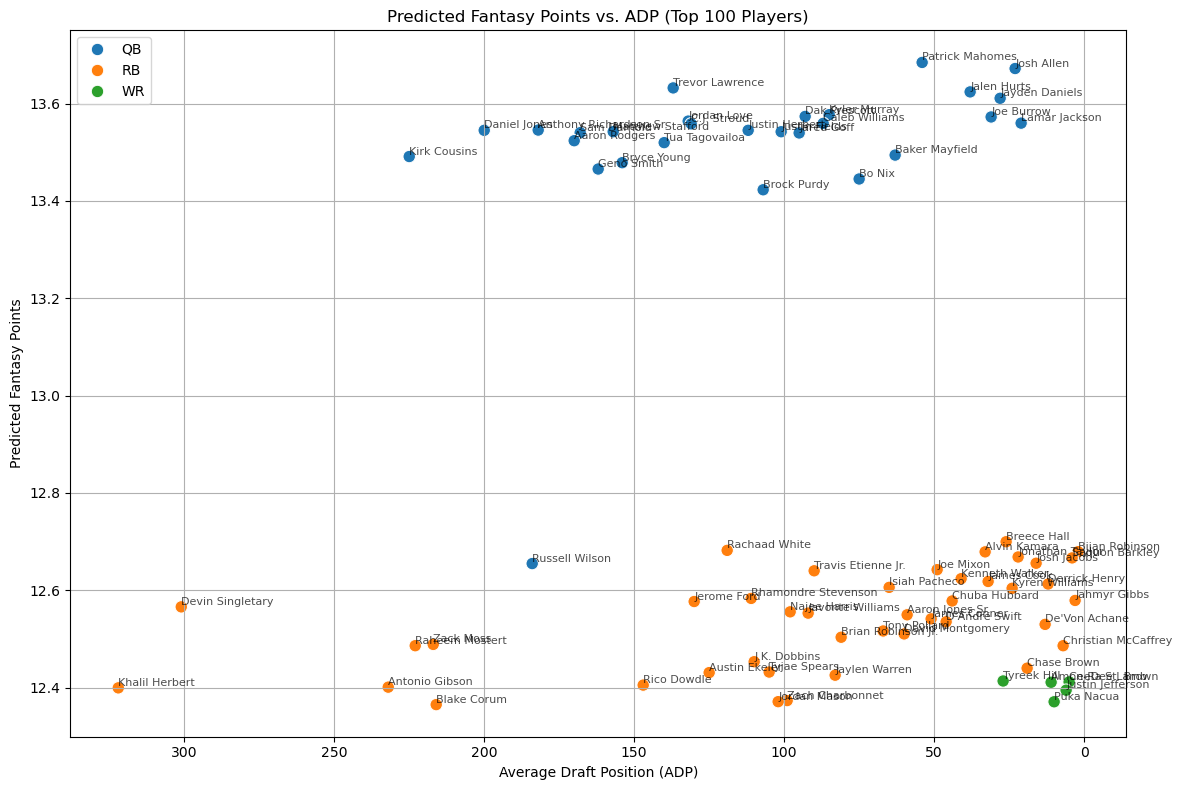

In [13]:
# Use top 75 players to avoid clutter (ish)
top_players = ranked_players.head(75)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=top_players, x='ADP', y='PredictedFantasyPoints', hue='Position', s=80)

# Add player names as text labels
for _, row in top_players.iterrows():
    plt.text(row['ADP'], row['PredictedFantasyPoints'], row['Player'],
             fontsize=8, alpha=0.7, ha='left', va='bottom')

plt.title('Predicted Fantasy Points vs. ADP (Top 100 Players)')
plt.xlabel('Average Draft Position (ADP)')
plt.ylabel('Predicted Fantasy Points')
plt.gca().invert_xaxis()  # ADP: smaller = better pick
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

I was trying to identify draft day steals but thats hard to see... We will play around with a few others.

#### Top 25 Players: Predicted Fantasy Points (Bar Plot)

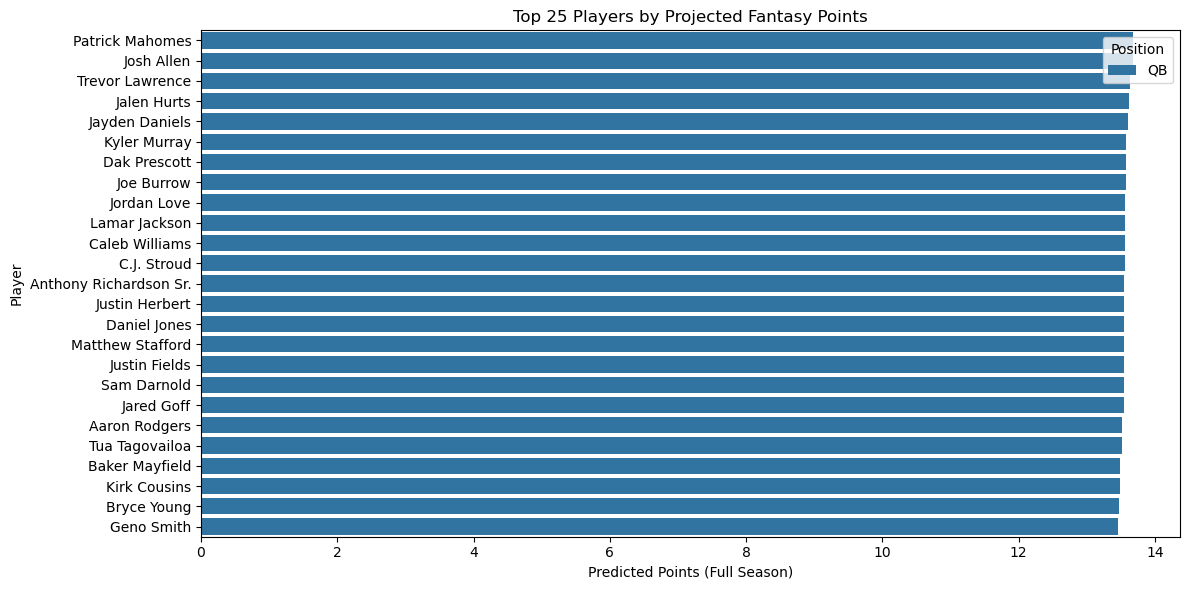

In [14]:
top25 = ranked_players.head(25)

plt.figure(figsize=(12, 6))
sns.barplot(data=top25, x='PredictedFantasyPoints', y='Player', hue='Position', dodge=False)
plt.title('Top 25 Players by Projected Fantasy Points')
plt.xlabel('Predicted Points (Full Season)')
plt.ylabel('Player')
plt.tight_layout()
plt.show()


This bar chart highlights the top projected players overall, making it easy to see which positions dominate the top tier.

#### ADP vs. Positional Rank (Heatmap or Line Plot)

Lets revisit ADP graph ideas. How about we group players by position and compare ADP rank to model rank:

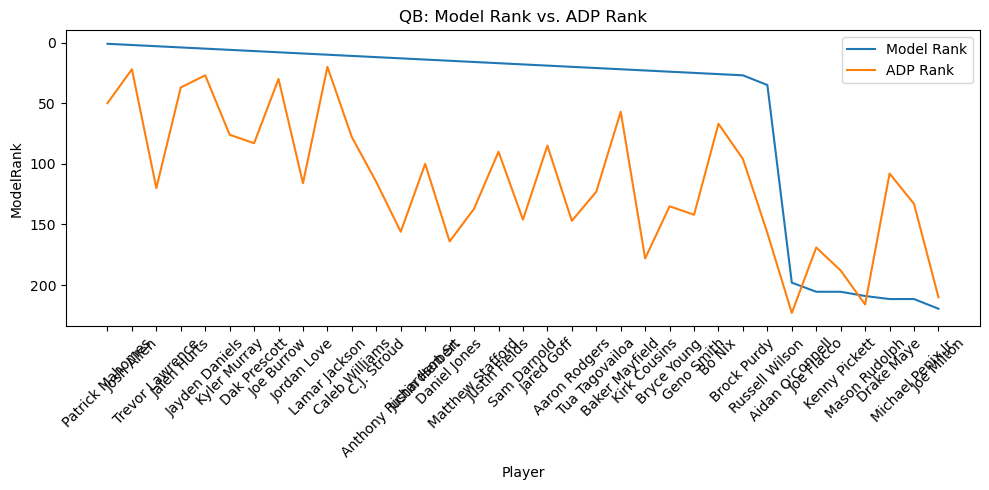

In [15]:
ranked_players['ModelRank'] = ranked_players['PredictedFantasyPoints'].rank(ascending=False)
ranked_players['ADPRank'] = ranked_players['ADP'].rank()

qb_comp = ranked_players[ranked_players['Position'] == 'QB'].head(35)

plt.figure(figsize=(10, 5))
sns.lineplot(data=qb_comp, x='Player', y='ModelRank', label='Model Rank')
sns.lineplot(data=qb_comp, x='Player', y='ADPRank', label='ADP Rank')
plt.title('QB: Model Rank vs. ADP Rank')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

Comparing how my model values players vs how the public is drafting them. This shows me some potential sleepers....

Model is optimistic about:
- **Kyler Murray:**
    - Model rank (way higher!) > ADP rank
    - My model says he will have a strong fantasy year, could be a late-round steal? His health is returning and theres always that rushing upside!
- Aaron Rodgers:
    - ADP is much lower than my model's rank
    - I dont like this tho... dont know if I can trust gramps
- **Jared Goff:**
    - Model ranks him way higher than public perception and I actually love goff
    - *Consistency* and high passing volume are very underrated

These QBs are at the bottom of both ranks (not surprising): Michael Penix Jr., Drake Maye, Joe Flacco, Mason Rudolph